### Model inspired by:

- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen

### Implementation aspects:

- This implementation is more like pseudo steady-state finite difference method rather than fully dynamic FEM

In [1]:
import numpy as np
import inspect
import matplotlib.pyplot as plt
import scipy
from datetime import datetime
from scipy.optimize import root
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys

In [3]:
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [4]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

### Modelling data:

In [5]:
mp = 96       #  (submerged pipe weight) [kg/m]
N = 20        # number of modelling nodes

In [6]:
mi = [mp for i in range(N)]

In [7]:
# Vessel:

# L - the hull length
# Xg - x-center of gravity

L = 84.6 # [m]
B = 12
H = 13
Xg = L/2 # [m]
mn = 27_162_500  #  123_000_000 # mass of the vessel, [kg]

In [8]:
lx, ly, lz = L/2, B/2, H/2

In [9]:
vessel_mass = mn/L # mass over length of the vessel

In [10]:
diag_Jrho0 = 1e2*np.array([1, 1, 2]) # [m^4] 
Jrho0 = np.diag(diag_Jrho0)

In [11]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [12]:
Ar=np.pi*((d0/2)**2-(dI/2)**2)   

In [13]:
E = 210e9

In [14]:
h = 100 # water depth

In [15]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [16]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [17]:
# Underwater current: 
dv1_curr = np.zeros(N)
dv2_curr = np.zeros(N)
dv3_curr = np.zeros(N)

In [18]:
# Constants: 

In [19]:
diag_DT = 1.5*np.array([1, 1, 1])
DT=np.diag(diag_DT)

In [20]:
diag_CT = 1e9*np.array([1, 1, 1 ])  
CT=np.diag(diag_CT)

In [21]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [22]:
diag_DR = 1.5*np.array([1, 1, 1])
DR=np.diag(diag_DR)

In [23]:
# for testing:

In [24]:
φ = np.random.rand(N)
θ = np.random.rand(N)
ψ = np.random.rand(N)

In [25]:
φ

array([0.64232837, 0.72654864, 0.11784964, 0.38476027, 0.25301588,
       0.53212378, 0.59551052, 0.15876766, 0.63257123, 0.71436774,
       0.23199529, 0.41495084, 0.21189376, 0.41628069, 0.66193285,
       0.32060031, 0.42025741, 0.63857954, 0.72222368, 0.50957287])

In [26]:
dφ = np.random.rand(N)
dθ = np.random.rand(N)
dψ = np.random.rand(N)

In [27]:
ddφ = np.random.rand(N)
ddθ = np.random.rand(N)
ddψ = np.random.rand(N)

In [28]:
x = np.random.rand(N)
y = np.random.rand(N)
z = np.random.rand(N)

In [29]:
dx = np.random.rand(N)
dy = np.random.rand(N)
dz = np.random.rand(N)

### Main functions:

In [30]:
def Π0(φθψ):
    φ0,θ0,ψ0=φθψ
    return np.array([[np.cos(θ0),0,np.cos(φ0)*np.sin(θ0)],
                  [0,1,-np.sin(φ0)],
                  [-np.sin(θ0),0,np.cos(φ0)*np.cos(θ0)]])

In [31]:
def Π(φ,θ,ψ):
    φθψ=np.stack((φ,θ,ψ), axis=1)
    return np.apply_along_axis(Π0, 1, φθψ)

In [32]:
Π(φ,θ,ψ)

array([[[ 0.55045966,  0.        ,  0.66847639],
        [ 0.        ,  1.        , -0.5990614 ],
        [-0.83486176,  0.        ,  0.44075475]],

       [[ 0.78457886,  0.        ,  0.46345408],
        [ 0.        ,  1.        , -0.6642938 ],
        [-0.62002904,  0.        ,  0.58645039]],

       [[ 0.9427733 ,  0.        ,  0.33112164],
        [ 0.        ,  1.        , -0.11757704],
        [-0.33343442,  0.        ,  0.936234  ]],

       [[ 0.56360817,  0.        ,  0.76564903],
        [ 0.        ,  1.        , -0.37533695],
        [-0.82604227,  0.        ,  0.52240189]],

       [[ 0.786573  ,  0.        ,  0.59783735],
        [ 0.        ,  1.        , -0.25032495],
        [-0.61749731,  0.        ,  0.76152999]],

       [[ 0.87322231,  0.        ,  0.41994076],
        [ 0.        ,  1.        , -0.50736461],
        [-0.48732206,  0.        ,  0.75248316]],

       [[ 0.69155817,  0.        ,  0.59798209],
        [ 0.        ,  1.        , -0.56093147],
        

In [33]:
def w_e(φ,θ,ψ,dφ,dθ,dψ): 
    return np.einsum('ijk,ik->ij', Π(φ,θ,ψ), np.stack((dφ,dθ,dψ), axis=1))

In [34]:
w_e(φ,θ,ψ,dφ,dθ,dψ)

array([[ 0.49057927,  0.58181986, -0.03390166],
       [ 0.1396928 ,  0.44415997, -0.08457269],
       [ 0.2803446 ,  0.7573569 ,  0.57466689],
       [ 0.63875163,  0.06130079, -0.76080417],
       [ 1.30234141, -0.13713698,  0.18443686],
       [ 0.98525762, -0.05673665,  0.40791926],
       [ 0.34855321,  0.60531124, -0.26568958],
       [ 0.56752504,  0.03192418,  0.53636749],
       [ 0.83792588,  0.52439762,  0.13436869],
       [ 1.09500941, -0.33622463, -0.08034623],
       [ 1.08399353,  0.74378756,  0.28750024],
       [ 0.68088625,  0.09050698,  0.50148257],
       [ 0.63364098,  0.60469323,  0.08599973],
       [ 0.92649682,  0.15709766, -0.10691319],
       [ 0.66161277,  0.72771209, -0.07741941],
       [ 0.24083368,  0.20686905,  0.39232985],
       [ 0.72139814,  0.53930595,  0.21783242],
       [ 0.30345491, -0.19519844,  0.68851205],
       [ 0.75862376, -0.37946098,  0.53055104],
       [ 0.58380742, -0.00368965,  0.49784708]])

In [35]:
def dw_e(φ,θ,ψ,dφ,dθ,dψ,ddφ,ddθ,ddψ):
    return (np.einsum('ijk,ik->ij', Π(φ,θ,ψ), np.stack((ddφ,ddθ,ddψ), axis=1))+
        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1)))

In [36]:
dw_e(φ,θ,ψ,dφ,dθ,dψ,ddφ,ddθ,ddψ)

array([[ 1.40873734,  1.30071046, -0.27596624],
       [ 0.88157234,  0.82584611, -0.16262838],
       [ 1.1028601 ,  1.58653234,  0.62904513],
       [ 1.47845078,  0.60250068, -0.14614975],
       [ 1.82473309, -0.75350933,  0.55913015],
       [ 1.72101267,  0.36676486,  0.61823993],
       [ 0.6380302 ,  0.50615786, -0.08483767],
       [ 1.41541583,  0.51721365,  0.32606101],
       [ 1.22634739,  0.77372183, -0.2289766 ],
       [ 1.7328499 , -0.42763182,  0.04148062],
       [ 2.06708724,  0.30716074, -0.1125276 ],
       [ 1.00792607,  0.16151587,  1.04567264],
       [ 1.24276288,  0.83739028,  0.25636808],
       [ 1.86318801,  0.74762877, -0.14535788],
       [ 1.081001  ,  1.03849472, -0.46099164],
       [ 0.9569439 ,  1.20391371,  0.23749085],
       [ 1.32270412,  0.96173811, -0.21256751],
       [ 1.12887462,  0.97053278,  0.81325865],
       [ 0.92258459,  0.15729702,  0.49209354],
       [ 1.45284387,  0.17741781,  0.4168687 ]])

In [37]:
def phi(x,y,z): return np.stack((x,y,z), axis=1) 
def theta(φ,θ,ψ): return np.stack((φ,θ,ψ), axis=1) 

In [38]:
phi(x,y,z)

array([[0.46522148, 0.36308405, 0.81841006],
       [0.98432932, 0.6360321 , 0.86109397],
       [0.93386994, 0.12137483, 0.06789743],
       [0.33748393, 0.29101559, 0.77134144],
       [0.10596814, 0.89433334, 0.29896019],
       [0.55413529, 0.61315891, 0.02078638],
       [0.6343162 , 0.32067547, 0.5567053 ],
       [0.02925764, 0.4216321 , 0.44450761],
       [0.84466113, 0.21031372, 0.66284879],
       [0.17060862, 0.09842421, 0.08885084],
       [0.08878871, 0.57977079, 0.011262  ],
       [0.59289563, 0.59601034, 0.70973078],
       [0.0320952 , 0.93347537, 0.83673955],
       [0.33485362, 0.8912584 , 0.78351113],
       [0.38018802, 0.48665023, 0.30805244],
       [0.79814641, 0.55678478, 0.90124623],
       [0.56771404, 0.98694704, 0.26549102],
       [0.1028336 , 0.88539112, 0.20600462],
       [0.25223999, 0.44585736, 0.785365  ],
       [0.04894023, 0.26993126, 0.01249612]])

In [39]:
theta(φ,θ,ψ)

array([[0.64232837, 0.98788161, 0.18624918],
       [0.72654864, 0.66877971, 0.21016101],
       [0.11784964, 0.33994413, 0.03319467],
       [0.38476027, 0.97204899, 0.65135151],
       [0.25301588, 0.66555694, 0.14269504],
       [0.53212378, 0.50902039, 0.16845174],
       [0.59551052, 0.80715232, 0.28218688],
       [0.15876766, 0.31486281, 0.42972   ],
       [0.63257123, 0.36315629, 0.15893196],
       [0.71436774, 0.7968303 , 0.98586662],
       [0.23199529, 0.61877801, 0.3912213 ],
       [0.41495084, 0.35119712, 0.29511626],
       [0.21189376, 0.75415298, 0.17676996],
       [0.41628069, 0.97570132, 0.5382916 ],
       [0.66193285, 0.45438058, 0.40437256],
       [0.32060031, 0.39468409, 0.08301991],
       [0.42025741, 0.24618859, 0.80591198],
       [0.63857954, 0.04983224, 0.46389499],
       [0.72222368, 0.06348484, 0.07095787],
       [0.50957287, 0.54184509, 0.46336659]])

In [40]:
def ω(φ,θ,ψ): 
    return np.einsum('ijk,ik->ij', Π(φ,θ,ψ), theta(φ,θ,ψ))

In [41]:
ω(x,y,z)

array([[ 6.94666132e-01, -4.07168664e-03,  5.18518735e-01],
       [ 1.07492613e+00, -8.11740179e-02, -2.01336071e-01],
       [ 9.31888707e-01,  6.67902181e-02, -7.29868240e-02],
       [ 5.32126731e-01,  3.56136367e-02,  6.00394877e-01],
       [ 2.98159204e-01,  8.62712340e-01,  1.03477732e-01],
       [ 4.63362460e-01,  6.02220947e-01, -3.04423366e-01],
       [ 7.43323825e-01, -9.24304934e-03,  2.25613157e-01],
       [ 2.08532275e-01,  4.08628713e-01,  3.93431347e-01],
       [ 9.17932126e-01, -2.85328912e-01,  2.54086465e-01],
       [ 1.78387119e-01,  8.33389215e-02,  7.03721793e-02],
       [ 8.04249708e-02,  5.78772165e-01, -3.92567716e-02],
       [ 8.21076443e-01,  1.99437775e-01,  1.54294135e-01],
       [ 6.91233277e-01,  9.06624655e-01,  4.71846128e-01],
       [ 7.86047135e-01,  6.33772411e-01,  2.04566641e-01],
       [ 4.69828960e-01,  3.72333486e-01,  7.50444518e-02],
       [ 1.01004788e+00, -8.85647116e-02,  1.12293283e-01],
       [ 4.99710108e-01,  8.44190900e-01

In [42]:
def Ret(φ,θ,ψ):
    
    def Ret0(arr):
        φ,θ,ψ=arr
        Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

        Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

        Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])


        return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )
    
    arr=np.stack((φ,θ,ψ), axis=1)
    return np.apply_along_axis(Ret0, 1, arr)

In [43]:
Ret(φ,θ,ψ)

array([[[ 6.33551688e-01,  3.89553039e-01,  6.68476393e-01],
        [ 1.48269601e-01,  7.86855492e-01, -5.99061400e-01],
        [-7.59360510e-01,  4.78651089e-01,  4.40754752e-01]],

       [[ 8.53241663e-01,  2.39142180e-01,  4.63454078e-01],
        [ 1.55935552e-01,  7.31025205e-01, -6.64293801e-01],
        [-4.97657280e-01,  6.39072115e-01,  5.86450394e-01]],

       [[ 9.43555062e-01,  7.89333501e-03,  3.31121638e-01],
        [ 3.29583673e-02,  9.92516693e-01, -1.17577037e-01],
        [-3.29571828e-01,  1.21853637e-01,  9.36233999e-01]],

       [[ 6.36185870e-01, -9.51267485e-02,  7.65649032e-01],
        [ 5.61937025e-01,  7.37122078e-01, -3.75336945e-01],
        [-5.28672222e-01,  6.69030600e-01,  5.22401893e-01]],

       [[ 8.00560830e-01,  4.11443813e-02,  5.97837350e-01],
        [ 1.37683541e-01,  9.58321794e-01, -2.50324954e-01],
        [-5.83220027e-01,  2.82712716e-01,  7.61529986e-01]],

       [[ 9.02315300e-01,  9.73491350e-02,  4.19940765e-01],
        [ 1.44

In [44]:
def d_s(func, a, b, c, φ, θ, ψ): 
    
    sig = inspect.signature(func)
    num_args = len(sig.parameters)
    
    if num_args==3:
        fu = func(a, b, c)
    else:
        fu = func(a, b, c, φ, θ, ψ)

    def S(arr):
        a1, a2, a3 = arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    
    S0 = np.apply_along_axis(S, 1, ω(φ,θ,ψ))
    
    return np.einsum('ijk,ik->ij',S0, fu).T

In [45]:
d_s(phi,x,y,z,φ, θ, ψ)

array([[ 0.88207852,  0.66379622,  0.02381369,  0.55467687,  0.23083963,
         0.09008361,  0.4473578 , -0.0396196 ,  0.2004928 ,  0.01245307,
        -0.09584041,  0.09875692,  0.61777048,  0.65518746,  0.06531587,
         0.36027069, -0.62513609, -0.34791524,  0.00975789, -0.01866321],
       [-0.6025521 , -0.89682827, -0.01596382, -0.5443688 , -0.09004243,
        -0.08458445, -0.49358115, -0.11514867, -0.51072686, -0.0900307 ,
         0.01097406, -0.27675554, -0.22884408, -0.52528501, -0.22783704,
        -0.33437113,  0.19115727, -0.10022418, -0.56687408, -0.00396307],
       [-0.23409392, -0.0963687 , -0.29899927, -0.03730478,  0.1875377 ,
         0.09358039, -0.22540999,  0.1118306 , -0.09343852,  0.0758192 ,
         0.1906507 ,  0.14991124,  0.23160475,  0.31751021,  0.27931814,
        -0.11248425,  0.62614711,  0.60442805,  0.3186845 ,  0.15870027]])

In [46]:
d_s(theta, φ, θ, ψ, φ, θ, ψ)

array([[ 6.11872880e-01,  3.30057411e-01,  1.39481477e-02,
         4.52093757e-01,  1.21535182e-01,  1.38823409e-01,
         3.99896942e-01, -5.44398835e-03,  8.08731827e-02,
         1.41052865e-01,  9.82440121e-02,  2.96078624e-02,
         1.41159338e-01,  4.75105857e-01,  8.50155201e-02,
         5.05434941e-02, -2.17049615e-01, -1.22106798e-01,
         7.11892618e-04,  1.00951758e-01],
       [-3.80765017e-01, -3.78018887e-01, -5.02135638e-03,
        -4.57447893e-01, -5.26075927e-02, -1.60726982e-01,
        -3.23780256e-01, -6.50893647e-02, -1.67563183e-01,
        -1.01044172e+00, -1.19598660e-01, -9.64125868e-02,
        -5.22674890e-02, -3.73683483e-01, -2.99714274e-01,
        -4.32894607e-02, -2.16140066e-01, -8.72218535e-02,
        -4.61003684e-02, -2.56276038e-01],
       [-9.05913003e-02,  6.18982628e-02,  1.90381251e-03,
         4.15618970e-01,  2.98750211e-02,  4.71474702e-02,
         8.22049131e-02,  4.97034110e-02,  6.09919858e-02,
         7.14485059e-01,  1.3

In [47]:
def ne(x, y, z, φ, θ, ψ):
    RET = Ret(φ,θ,ψ)
    A = np.einsum('ijk,ikp->ijp',np.einsum('ijk,kp->ijp',RET, CT), np.transpose(RET,(0,2,1))) 
    B = d_s(phi, x, y, z, φ, θ, ψ).T
    t0 = np.diff(phi(x,y,z),axis=0)
    t1 = np.insert(t0, 0, [0,0,0], axis=0)
    return np.einsum('ijk,ik->ij', A, B - t1 )

In [48]:
ne(x, y, z, φ, θ, ψ)

array([[ 8.82078523e+08, -6.02552097e+08, -2.34093923e+08],
       [ 1.44688384e+08, -1.16977632e+09, -1.39052613e+08],
       [ 7.42730670e+07,  4.98693451e+08,  4.94197265e+08],
       [ 1.15106288e+09, -7.14009563e+08, -7.40748794e+08],
       [ 4.62355421e+08, -6.93360183e+08,  6.59918951e+08],
       [-3.58083540e+08,  1.96589984e+08,  3.71754203e+08],
       [ 3.67176890e+08, -2.01097714e+08, -7.61328912e+08],
       [ 5.65438969e+08, -2.16105300e+08,  2.24028287e+08],
       [-6.14910685e+08, -2.99408478e+08, -3.11779705e+08],
       [ 6.86505577e+08,  2.18588026e+07,  6.49817142e+08],
       [-1.40204936e+07, -4.70372522e+08,  2.68239546e+08],
       [-4.05350000e+08, -2.92995092e+08, -5.48557545e+08],
       [ 1.17857091e+09, -5.66309112e+08,  1.04595976e+08],
       [ 3.52429035e+08, -4.83068044e+08,  3.70738626e+08],
       [ 1.99814698e+07,  1.76771131e+08,  7.54776829e+08],
       [-5.76876996e+07, -4.04505677e+08, -7.05678037e+08],
       [-3.94703717e+08, -2.39004993e+08

In [49]:
d_s(ne, x, y, z, φ, θ, ψ)

array([[-4.78796306e+08, -4.56371150e+08,  1.70168480e+08,
        -5.22926929e+08,  3.82658058e+08,  1.83517641e+08,
        -5.48013067e+08,  1.31881221e+08, -1.15332413e+08,
         9.78767844e+07,  2.24440649e+08, -9.49134259e+07,
         6.41649351e+07,  2.47831776e+08,  1.56053130e+08,
        -2.80502826e+08,  4.18166350e+07, -1.50945823e+08,
        -3.38985482e+06,  2.79797725e+08],
       [-2.88693958e+08,  4.54618317e+07, -6.09503000e+07,
         5.55879431e+08, -2.09625000e+08, -1.51570948e+08,
         3.43385613e+08,  1.37069708e+08,  2.63051645e+08,
        -6.63914408e+08, -1.12393050e+08,  2.19770596e+08,
        -5.10641659e+07, -2.61884984e+08, -5.54663395e+08,
         2.33141744e+08, -9.81849475e+08, -3.95961328e+08,
         1.87745926e+08, -5.85571293e+08],
       [-1.06103903e+09, -8.57314186e+08,  3.59301473e+07,
        -1.34839910e+09, -4.88347327e+08,  2.56922386e+08,
        -3.55000042e+08, -2.00641141e+08, -2.51483961e+07,
        -8.10698595e+07, -1.8

In [50]:
def me(a, b, c, φ, θ, ψ):
    RET = Ret(φ,θ,ψ)
    A = np.einsum('ijk,ikp->ijp',np.einsum('ijk,kp->ijp', RET, CR), np.transpose(RET,(0,2,1))) 
    return np.einsum('ijk,ik->ij', A, ω(φ,θ,ψ))

In [51]:
me(φ, θ, ψ, φ, θ, ψ)

array([[ 4.78079042e+10,  8.76306909e+10, -4.54165185e+10],
       [ 6.67434680e+10,  5.29171058e+10, -3.27232246e+10],
       [ 1.22096967e+10,  3.36041197e+10, -8.21715068e+08],
       [ 7.15560685e+10,  7.27572700e+10,  2.24390143e+09],
       [ 2.84323887e+10,  6.29836814e+10, -4.75700690e+09],
       [ 5.35402114e+10,  4.23553937e+10, -1.32558561e+10],
       [ 5.80572869e+10,  6.48864816e+10, -2.68593422e+10],
       [ 2.82367004e+10,  2.46923439e+10,  3.54287404e+10],
       [ 6.36848111e+10,  2.69192472e+10, -1.04885686e+10],
       [ 1.03198724e+11,  1.50949779e+10,  9.74295690e+08],
       [ 4.09825230e+10,  5.28828474e+10,  1.75579854e+10],
       [ 4.82533472e+10,  2.32222496e+10,  1.10834539e+10],
       [ 2.72761604e+10,  7.16976194e+10, -1.91201050e+09],
       [ 6.41050457e+10,  7.58036876e+10, -6.87310507e+09],
       [ 7.34766952e+10,  2.05835959e+10, -3.91985721e+08],
       [ 3.26247907e+10,  3.68521504e+10, -5.05439002e+09],
       [ 5.86903485e+10, -8.26198557e+09

In [52]:
d_s(me, φ, θ, ψ, φ, θ, ψ)

array([[ 7.62939453e-06, -3.81469727e-06, -1.19209290e-07,
        -4.76837158e-07,  0.00000000e+00,  9.53674316e-07,
        -3.81469727e-06,  1.90734863e-06,  4.76837158e-07,
         5.06639481e-07,  0.00000000e+00, -9.53674316e-07,
        -1.90734863e-06,  5.72204590e-06,  9.98377800e-07,
         0.00000000e+00,  9.53674316e-07, -2.86102295e-06,
         3.72529030e-09,  4.76837158e-07],
       [-8.65685536e-06,  2.31860868e-06,  7.73162400e-08,
         6.22630263e-07,  3.65289688e-07, -8.05061984e-08,
        -1.77307692e-06, -6.30068227e-09, -4.72358163e-08,
        -4.15698162e-06, -3.48501361e-07,  3.03762776e-07,
         6.82751739e-07, -4.45769302e-06, -3.55535151e-06,
        -1.52425891e-07,  2.40426677e-06,  1.09189693e-06,
         1.44796502e-07, -2.46729946e-06],
       [-1.52587891e-05,  0.00000000e+00,  9.53674316e-07,
         0.00000000e+00,  3.81469727e-06,  3.81469727e-06,
        -7.62939453e-06, -9.53674316e-07,  1.90734863e-06,
         9.53674316e-06,  3.8

In [53]:
def fD(dx,dy,dz): 
    
    A=np.vstack([np.abs(dx-dv1_curr)*dx-(dv1_curr),
                 ((dy-dv2_curr)**2+(dz-dv3_curr)**2)**0.5*(dy-dv2_curr),
                 ((dy-dv2_curr)**2+(dz-dv3_curr)**2)**0.5*(dz-dv3_curr)])
    
    return 1/2*d0*qw*np.dot(DT, A)*9.81

In [54]:
fD(dx,dy,dz).T

array([[3.64556171e+02, 2.96343268e+03, 1.13428169e+03],
       [5.44616142e+03, 2.65502104e+03, 5.45000418e+02],
       [4.64016323e+03, 4.16730839e+03, 5.23898587e+03],
       [4.56143557e+02, 1.64789896e+03, 3.35614114e+03],
       [1.78978530e+00, 6.42393406e+03, 3.95107231e+03],
       [3.05610546e+01, 4.88379359e+02, 6.71750004e+02],
       [1.77745257e+01, 8.39586760e+02, 4.26121051e+03],
       [4.60806648e+03, 4.83914911e+03, 2.26534304e+03],
       [1.53318697e+03, 9.53206755e+02, 8.74311378e+02],
       [1.15512369e+03, 3.09762909e+02, 2.34694154e+02],
       [2.30614786e+01, 9.58431719e+01, 1.19267859e+02],
       [5.04940889e+01, 5.70528160e+03, 5.78088582e+03],
       [1.60915130e+03, 3.00954388e+03, 3.29065127e+03],
       [1.98232318e+03, 3.13533733e+03, 2.29777014e+03],
       [1.20870809e+03, 3.05456370e+03, 2.32311567e+03],
       [2.65768478e+03, 2.69310473e+02, 1.07879287e+03],
       [3.97137860e+02, 4.52659330e+03, 5.89859122e+03],
       [1.90859672e+00, 1.85613

In [55]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(N)])

In [56]:
def sigma(x,y,z):
    e3 = np.array([[0,0,1] for x in range(N)])
    
    k = phi(x,y,z)*e3+d0/2
    
    fg_e2 = np.linalg.norm(fg_e, ord=2)
    k0=np.zeros(k.shape)
    
    for i in range(k.shape[0]):
        for j in range(k.shape[1]):
            if k[i][j]<0:
                k0[i][j]=0
            elif 0<=k[i][j]<=d0/20:
                k0[i][j]=(fg_e2*10*k[i][j]**2)/((d0/8-d0/40)*d0)
            else:
                k0[i][j]=(fg_e2*(k[i][j]-d0/40))/(d0/8-d0/40)
                
    return k0         

In [57]:
sigma(x,y,z)

array([[2722.55397294, 2722.55397294, 8886.64707693],
       [2722.55397294, 2722.55397294, 9208.13333259],
       [2722.55397294, 2722.55397294, 3233.94317788],
       [2722.55397294, 2722.55397294, 8532.13612458],
       [2722.55397294, 2722.55397294, 4974.25947055],
       [2722.55397294, 2722.55397294, 2879.11259741],
       [2722.55397294, 2722.55397294, 6915.54165577],
       [2722.55397294, 2722.55397294, 6070.49215283],
       [2722.55397294, 2722.55397294, 7714.99219088],
       [2722.55397294, 2722.55397294, 3391.75990968],
       [2722.55397294, 2722.55397294, 2807.37697796],
       [2722.55397294, 2722.55397294, 8068.09750794],
       [2722.55397294, 2722.55397294, 9024.70095193],
       [2722.55397294, 2722.55397294, 8623.79568381],
       [2722.55397294, 2722.55397294, 5042.74044871],
       [2722.55397294, 2722.55397294, 9510.55179547],
       [2722.55397294, 2722.55397294, 4722.1767266 ],
       [2722.55397294, 2722.55397294, 4274.13764545],
       [2722.55397294, 2722.

In [58]:
def ne_hat(x,y,z,dx,dy,dz):
    return -fg_e.T - fD(dx,dy,dz) - sigma(x,y,z).T

In [59]:
ne_hat(x,y,z,dx,dy,dz)

array([[ -3087.11014415,  -8168.71539104,  -7362.71720436,
         -3178.69752968,  -2724.34375824,  -2753.11502751,
         -2740.32849867,  -7330.6204508 ,  -4255.74094466,
         -3877.67766687,  -2745.61545157,  -2773.04806188,
         -4331.70527583,  -4704.87715675,  -3931.26206644,
         -5380.23875755,  -3119.69183337,  -2724.46256967,
         -2906.60039541,  -2923.50329196],
       [ -5685.98665762,  -5377.57501668,  -6889.86236556,
         -4370.45293622,  -9146.48803371,  -3210.93333157,
         -3562.14073252,  -7561.70308672,  -3675.76072807,
         -3032.31688224,  -2818.39714487,  -8427.83557057,
         -5732.09785091,  -5857.89130018,  -5777.11767633,
         -2991.86444554,  -7249.14727039,  -4578.68741524,
         -7774.17965409,  -4459.66837997],
       [-10149.09330679,  -9881.2982924 ,  -8601.0935943 ,
        -12016.44180333,  -9053.49632035,  -3679.02714388,
        -11304.91671267,  -8463.99973669,  -8717.46811116,
         -3754.61860635,  -30

In [60]:
def Jrho(Ret,Jrho0): 
    ans=  Ret @ Jrho0 @ Ret
    return ans

In [61]:
RET = Ret(φ, θ, ψ)

In [62]:
Jrho(RET,Jrho0)

array([[[ -55.60825337,  119.32578409,   77.94164517],
        [ 112.04103456,   10.34176548,  -90.03383413],
        [-107.95082325,   50.2753528 ,  -40.58264642]],

       [[  30.40295122,   97.12261875,   78.01633128],
        [  90.82248197,  -27.73746698, -119.24972664],
        [ -90.86704777,  109.77351629,    3.26751892]],

       [[  67.22995798,    9.59788147,   93.15180944],
        [  14.1309922 ,   95.66951588,  -32.5943182 ],
        [ -92.40657721,   34.65073834,  162.96126488]],

       [[ -45.82775303,   89.38469433,  132.27526857],
        [ 116.85730165,   -1.23300885,  -23.8576071 ],
        [ -51.2739471 ,  124.24537995,  -11.00818021]],

       [[  -5.07788842,   41.04005794,  137.88478382],
        [  53.41582402,   78.2505469 ,  -53.88394129],
        [-131.62572997,   67.75219515,   74.04150775]],

       [[  48.71232638,   60.59974618,   96.15241752],
        [  66.522553  ,   20.96623483, -113.39194201],
        [ -90.28003436,  118.12085042,   69.8849565 ]],

### Static solution

In [63]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [64]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [65]:
Fx_0 = 82945396 #####??????
Fy_0 = 82945396 #####??????

In [66]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]

In [67]:
S=np.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [68]:
delta_x=horizontal_length/(N-1)

In [69]:
x0=[i*delta_x for i in range(N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(np.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

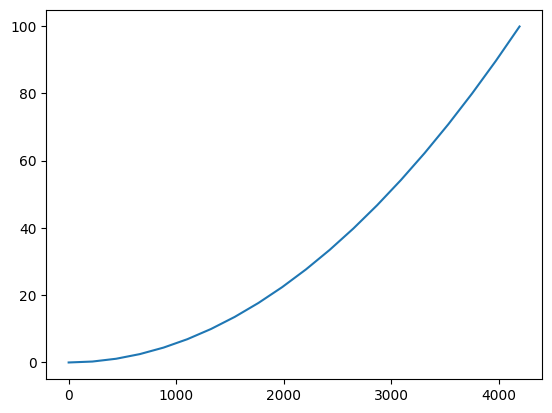

In [70]:
plt.plot(x0, z0)
plt.show()

In [71]:
q0=np.zeros(12*N)

In [72]:
for j in range(1,12):
    if j==1:
        q0[(j-1)*N:j*N]=x0
    elif j==5:
        q0[(j-1)*N:j*N]=z0

In [73]:
def static_func(Q): 
    t=0

    x,y,z=Q[0:N],Q[2*N:3*N],Q[4*N:5*N]
    dx,dy,dz=Q[1*N:2*N],Q[3*N:4*N],Q[5*N:6*N]
    φ,θ,ψ=Q[6*N:7*N],Q[8*N:9*N],Q[10*N:11*N]
    dφ,dθ,dψ=Q[7*N:8*N],Q[9*N:10*N],Q[11*N:12*N]
    
    RET = Ret(φ,θ,ψ)

    η = [x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]

    tau_force = np.array([-Fx_0,Fy_0,0,0,0,0])

    Z0 = tau_force[:3]
#     Z0 = RET @ tau_force[:3]
    
    Z1 = d_s(ne, x, y, z, φ, θ, ψ).T
    Z2 = ne_hat(x, y, z, dx, dy, dz).T


    Z = (Z1 + Z2 - Z0)


############################################################
    ddx,ddy, ddz = (Z/Ws[0]).T
############################################################
    
    C0 = np.einsum('ijk,kp->ijp', Π(φ,θ,ψ), tau_force[3:].reshape(3,1))
#     C0 = np.einsum('ijk,ikr->ijr', Π(φ,θ,ψ), RET) @ tau_force[3:]

    C1 = d_s(me, φ, θ, ψ, φ, θ, ψ)

    C = (C1.T - C0.squeeze())

    A0 = Jrho(RET,Jrho0)
    A = np.einsum('ijk,ikr->ijr', RET, np.einsum('ijk,ikr->ijr', A0, RET))
    A_fin = np.einsum('ijk,ikr->ijr',A, Π(φ,θ,ψ))

    B = np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1))
    
    D = me(φ, θ, ψ, φ, θ, ψ)
    
    G = np.cross(d_s(phi,x,y,z,φ, θ, ψ).T, ne(x, y, z, φ, θ, ψ))
    L = np.einsum('ijk,ik->ij',RET, (DR@D.T).T) 
    
    H = np.cross(w_e(φ,θ,ψ,dφ,dθ,dψ),np.einsum('ijk,ik->ij', A, w_e(φ,θ,ψ,dφ,dθ,dψ)))

#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A_fin, C + D + G - L - H - np.einsum('ijk,ik->ij',A, B)).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

    return ans

In [74]:
root_ = root(static_func, q0, method='df-sane')

In [75]:
root_

 message: too many function evaluations required
 success: False
     fun: [ 1.202e+02  1.202e+02 ...  0.000e+00  0.000e+00]
       x: [ 2.089e+03  2.310e+03 ...  0.000e+00  0.000e+00]
     nit: 446
    nfev: 1000
  method: df-sane

In [76]:
x0_, z0_=root_.x[:N],root_.x[4*N:5*N]

In [77]:
# q0 = root_.x

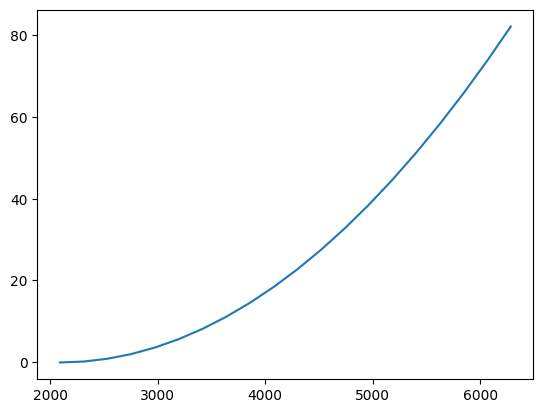

In [78]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [79]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return np.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [80]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L

    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3],
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])


    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = np.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])


    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)

In [81]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]

    return K

In [82]:
def FEA(coord, elcon, bc_node, bc_val, vessel_movement, coefs,
          E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):

    coord=np.array(coord)
    elcon=np.array(elcon)

    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))

    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
        
        
    glob_force=np.dot(K, np.array(vessel_movement))
    
    glob_force[-6:]=np.multiply(glob_force[-6:], coefs)
    


    F=np.zeros(len(coord)*6)
    for i in range(len(vessel_movement)):
        if vessel_movement[i]:
            F[i]=glob_force[i]

    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m

    bc=np.array([bc_node,
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=scipy.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, check_finite=True)[0]
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    

#     Q=np.dot(K,d).T-F
    return d, np.dot(K,d).T

In [83]:
# 10 The Space Frame Element - verification
d,f=FEA(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6,24)),
        bc_val=[0]*18,
        vessel_movement=[ -0.0705e-4, -0.0007e-4, 0.1418e-4, 0.0145e-4, 0.0175e-4,0.0114e-4,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                       ],
        coefs=[1,1,1,1,1,1])

In [84]:
d

array([-7.050e-06, -7.000e-08,  1.418e-05,  1.450e-06,  1.750e-06,
        1.140e-06,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00])

In [85]:
f

array([-9.99786375e+00, -3.59333333e-03,  2.00042617e+01,  5.25000000e-05,
        1.75000000e-05,  3.18500000e-04,  9.87000000e+00, -3.06133333e-02,
       -1.07846667e-01, -2.03000000e-03, -1.74020000e-01,  2.99600000e-02,
        9.03000000e-02, -3.92933333e-02, -1.98520000e+01,  3.86400000e-02,
        1.23200000e-01, -1.59600000e-03,  3.75637500e-02,  7.35000000e-02,
       -4.44150000e-02, -9.64425000e-02, -1.83750000e-03, -8.70975000e-02])

In [86]:
def PipeForce(X,Y,Z,vessel_movement,coefs, E=210e6, G=84e6,  
              A=Ar, Iy=39.4925/7860, Iz=39.4925/7860, J=1.0062*1e-2,
#               A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5
             ):
    coord=np.stack((X,Y,Z)).T
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])

    bc_node=list(range(6))
    bc_val=[0]*6

    vessel_move=np.zeros(len(X)*6)
    vessel_move[-6:]=vessel_movement

    d,f=FEA(coord,elcon,bc_node,bc_val,vessel_move, coefs, E,G,A,Iy,Iz,J)

    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])

    mom =[]
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])

    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3])
    fors[0][0]=0
    fors[0][1]=0
    fors[0][2]=0
    return np.array(fors), np.array(mom), np.array(angle)

In [87]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,
[0.01,
 0.02,
 0.03,
 0.01,
 -0.05,
 0.03],
 [1,1,1,1,1,1]
)

In [88]:
fors

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.50527295e-08, -4.74033186e-08, -2.53090548e-07],
       [-5.21540642e-08,  2.23828579e-07, -9.84000508e-08],
       [ 9.15024430e-08,  8.40755512e-08, -1.69909981e-07],
       [-4.09781933e-08,  4.28353815e-07, -2.44908733e-08],
       [ 1.86264515e-07, -1.34114089e-07,  2.54367478e-08],
       [-2.90572643e-07, -6.63130777e-08, -1.55763701e-07],
       [ 2.38418579e-07,  1.87951830e-07,  1.03027560e-08],
       [-1.63912773e-07, -1.54213922e-07,  1.50525011e-07],
       [ 3.87430191e-07,  5.49043762e-08,  2.03028321e-07],
       [-4.76837158e-07, -1.93242158e-07,  2.23517418e-07],
       [ 3.42726707e-07,  3.48204199e-08,  7.91624188e-08],
       [-2.38418579e-07, -4.29063221e-08, -2.14204192e-08],
       [-5.96046448e-08,  4.51109372e-09, -1.86264515e-09],
       [ 0.00000000e+00, -1.86992111e-09, -1.86264515e-09],
       [-7.76704559e-08,  7.35970731e-10, -4.36002584e-09],
       [-1.25036602e-07, -6.27919763e-10

### Vessle Simulation

In [89]:
sampleTime = 0.001              # sample time [seconds]
Number = 100000                      # number of samples

In [90]:
Number*sampleTime

100.0

In [91]:
vehicle=semisub('DPcontrol',0.1,-0.1,40.0,0,0)

In [92]:
[simTime, simData] = simulate(Number, sampleTime, vehicle)

In [93]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

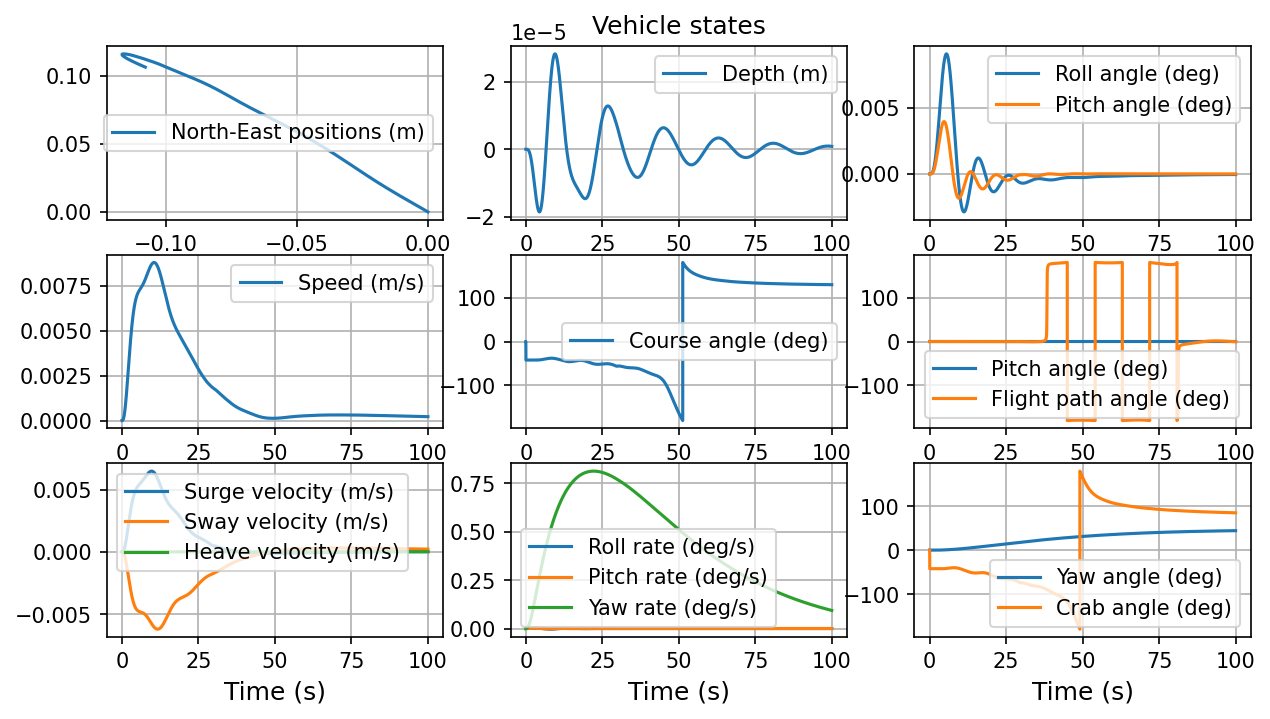

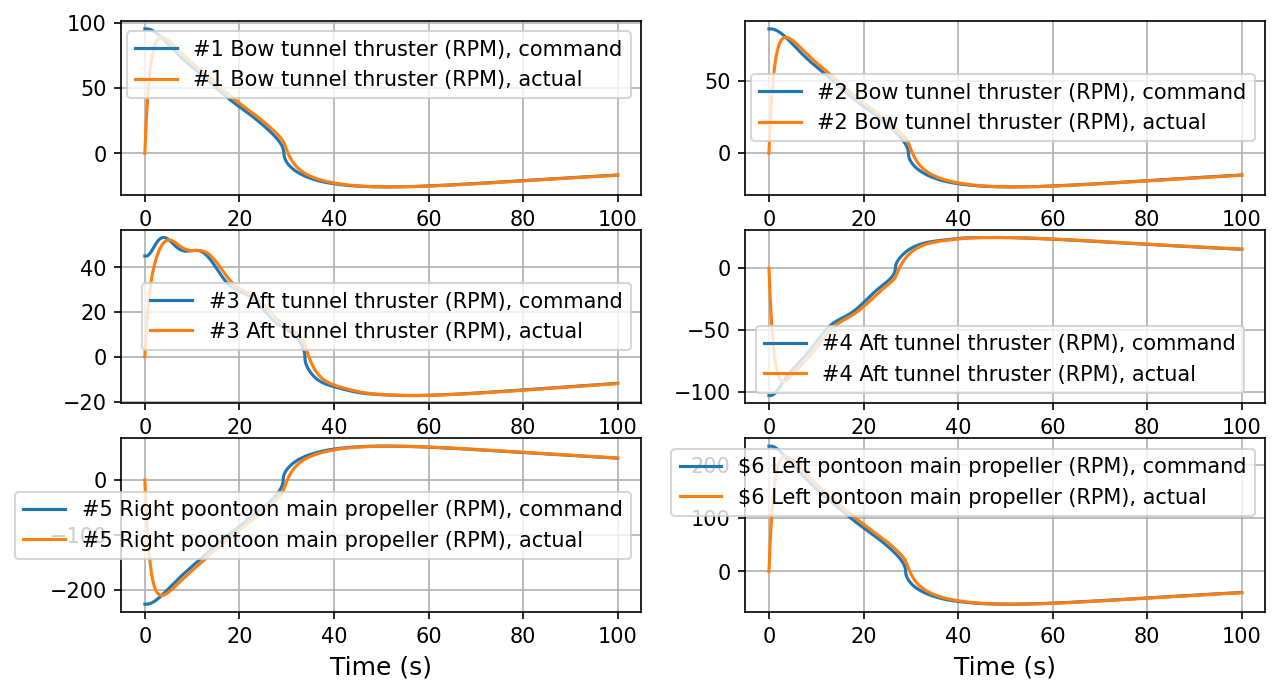

In [94]:
plotVehicleStates(simTime, simData, 1)
plotControls(simTime, simData, vehicle, 2)

In [95]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'

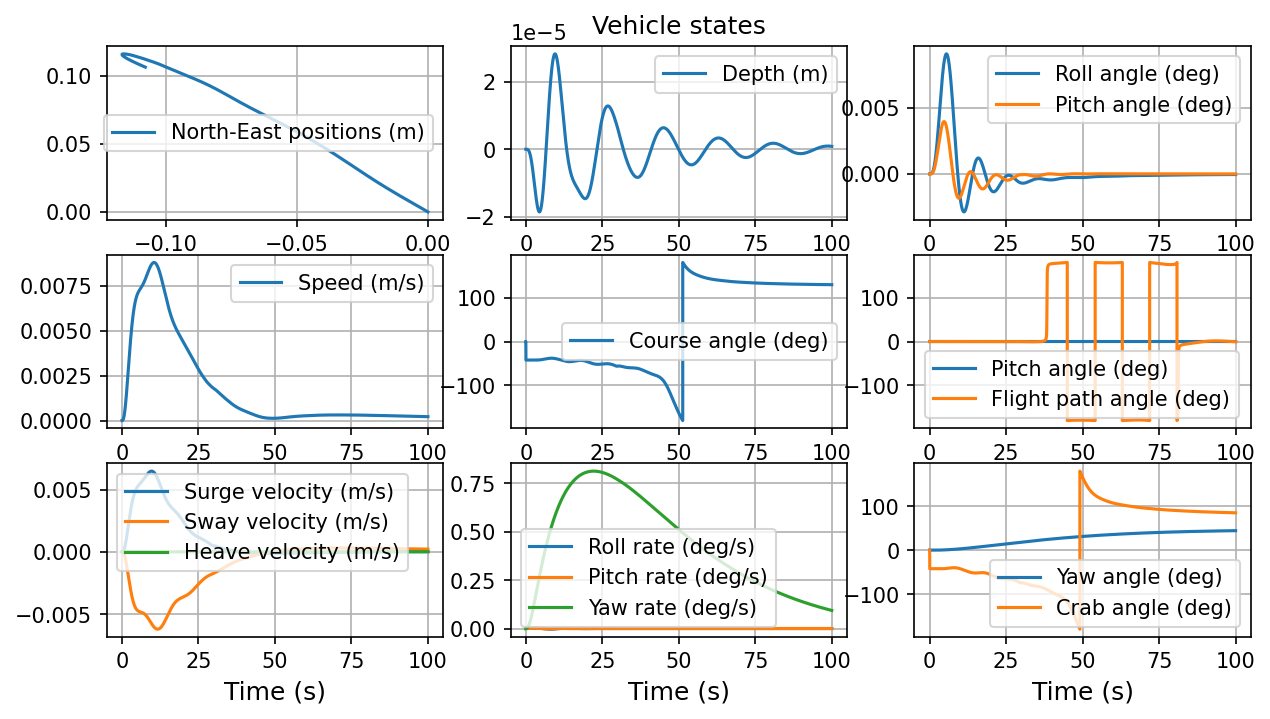

In [96]:
plotVehicleStates(simTime, simData, 3)

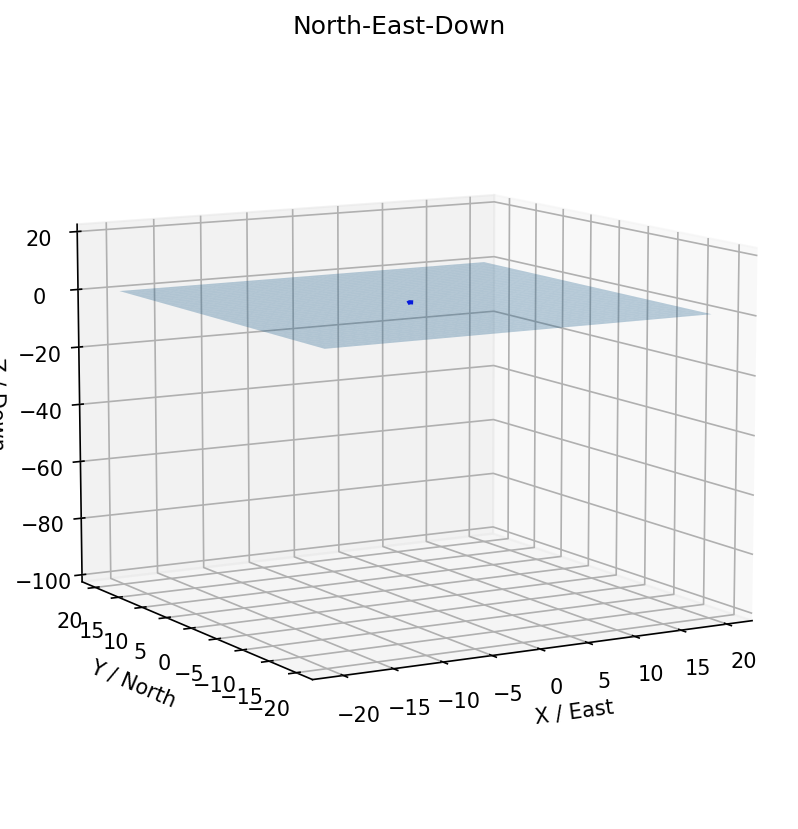

In [97]:
plot3D(simData, numDataPoints, FPS, filename, 3)

In [98]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [99]:
class MyTime:
    def __init__(self):
        self.my_t = 0
        self.v_m = np.array([0,0,0,0,0,0]).astype(np.float64)
        self.progression = [i for i in range(650)]
        self.wall_clock = datetime.now()
        self.vx=0
        self.vy=0
        self.vz=0

In [100]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())
    return np.array(ans)  

In [101]:
V_rho=np.zeros(Jrho0.shape)
np.fill_diagonal(V_rho, vessel_inertia)

In [102]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Jrho1=inert(V_rho, Jrho0, x0)

### Dynamics

In [104]:
def dynamic_func(t, Q, coefs, T):
    
    x,y,z=Q[0:N],Q[2*N:3*N],Q[4*N:5*N]
    dx,dy,dz=Q[1*N:2*N],Q[3*N:4*N],Q[5*N:6*N]
    φ,θ,ψ=Q[6*N:7*N],Q[8*N:9*N],Q[10*N:11*N]
    dφ,dθ,dψ=Q[7*N:8*N],Q[9*N:10*N],Q[11*N:12*N]
    
    idx = find_nearest(np.array(ans_t),  t)
    
    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
    RET = Ret(φ,θ,ψ)

    vessel_movement = np.zeros(6)
    
    del_t = abs(t-T.my_t)
    
    vessel_movement[0] = u_ve*del_t
    vessel_movement[1] = v_ve*del_t 
    vessel_movement[2] = -w_ve*del_t 
    vessel_movement[3] = p_ve*del_t 
    vessel_movement[4] = q_ve*del_t 
    vessel_movement[5] = r_ve*del_t
    
    fors, mom, angle = PipeForce(x, y, z, vessel_movement, coefs)
    
    Z0 = fors
#     Z0 = np.einsum('ijk,ik->ij', RET, fors).squeeze()  
    Z1 = d_s(ne, x, y, z, φ, θ, ψ).T
    Z2 = ne_hat(x, y, z, dx, dy, dz).T

    Z = (Z1 + Z2 
         - Z0
        )


############################################################
    ddx,ddy, ddz = (Z/(M_t.reshape(-1, 1))).T
############################################################
    
    C0 = np.einsum('ijk,ik->ij', Π(φ,θ,ψ), mom)
    
#     C0 = np.einsum('ijk,ik->ij', np.einsum('ijk,ikr->ijr', Π(φ,θ,ψ), RET), mom )
    
    C1 = d_s(me, φ, θ, ψ, φ, θ, ψ)

    C = (C1.T 
         - C0.squeeze()
        )

    A0 = Jrho(RET,Jrho1)
    A = np.einsum('ijk,ikr->ijr', RET, np.einsum('ijk,ikr->ijr', A0, RET))
    A_fin = np.einsum('ijk,ikr->ijr', A, Π(φ,θ,ψ))
    

    B = np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1))
    
    D = me(φ, θ, ψ, φ, θ, ψ)
    
    G = np.cross(d_s(phi,x,y,z,φ, θ, ψ).T, ne(x, y, z, φ, θ, ψ))
    
    L = np.einsum('ijk,ik->ij',RET, (DR@D.T).T) 

    H = np.cross(w_e(φ,θ,ψ,dφ,dθ,dψ),np.einsum('ijk,ik->ij', A, w_e(φ,θ,ψ,dφ,dθ,dψ)))
    

#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A_fin, (
        C + 
        D + 
        G - 
        L - 
        H - 
        np.einsum('ijk,ik->ij', A, B))).T
#############################################


    T.my_t=t
    T.vx=u_ve
    T.vy=v_ve
    T.vz=-w_ve

    if t>T.progression[0]:
        T.progression.pop(0)
        print('Physical time: ', t, ' Iteration wall clock time: ', datetime.now() - T.wall_clock )
        T.wall_clock = datetime.now()
    
    
    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

    return ans

In [105]:
# integration parameters
tspan = (0., 1)
T_ = MyTime()
coefs = [1, 1, 1, 1, 1, 1]

# initial conditions
# q0[8*N:9*N] = np.array([0.13*i/N for i in range(N)])
# q0[8*N+(N-1)] = 0.13
q0[6*N:7*N], q0[8*N:9*N], q0[10*N:11*N] = (np.array([0.01 for i in range(N)]),
                                          np.array([0.000001 for i in range(N)]),
                                          np.array([0.000236*i/N for i in range(N)]))

In [106]:
startTime1 = datetime.now()
us=solve_ivp(dynamic_func,
             tspan,
             q0,
             args=(coefs,T_,))
print(datetime.now() - startTime1)

Physical time:  1.7335491847419535e-06  Iteration wall clock time:  0:00:00.733926
1:05:34.557833


### Results

In [107]:
fin=us

In [108]:
fin

  message: Required step size is less than spacing between numbers.
  success: False
   status: -1
        t: [ 0.000e+00  1.734e-04 ...  1.459e-01  1.459e-01]
        y: [[ 0.000e+00 -1.298e-11 ... -9.192e-06 -9.192e-06]
            [ 2.207e+02  2.207e+02 ...  2.207e+02  2.207e+02]
            ...
            [ 0.000e+00 -3.301e-05 ... -2.757e+15 -2.947e+15]
            [ 0.000e+00 -3.679e-05 ... -2.554e+03 -2.554e+03]]
      sol: None
 t_events: None
 y_events: None
     nfev: 11798
     njev: 0
      nlu: 0

In [109]:
t=fin.t

In [110]:
fin=fin.y.T

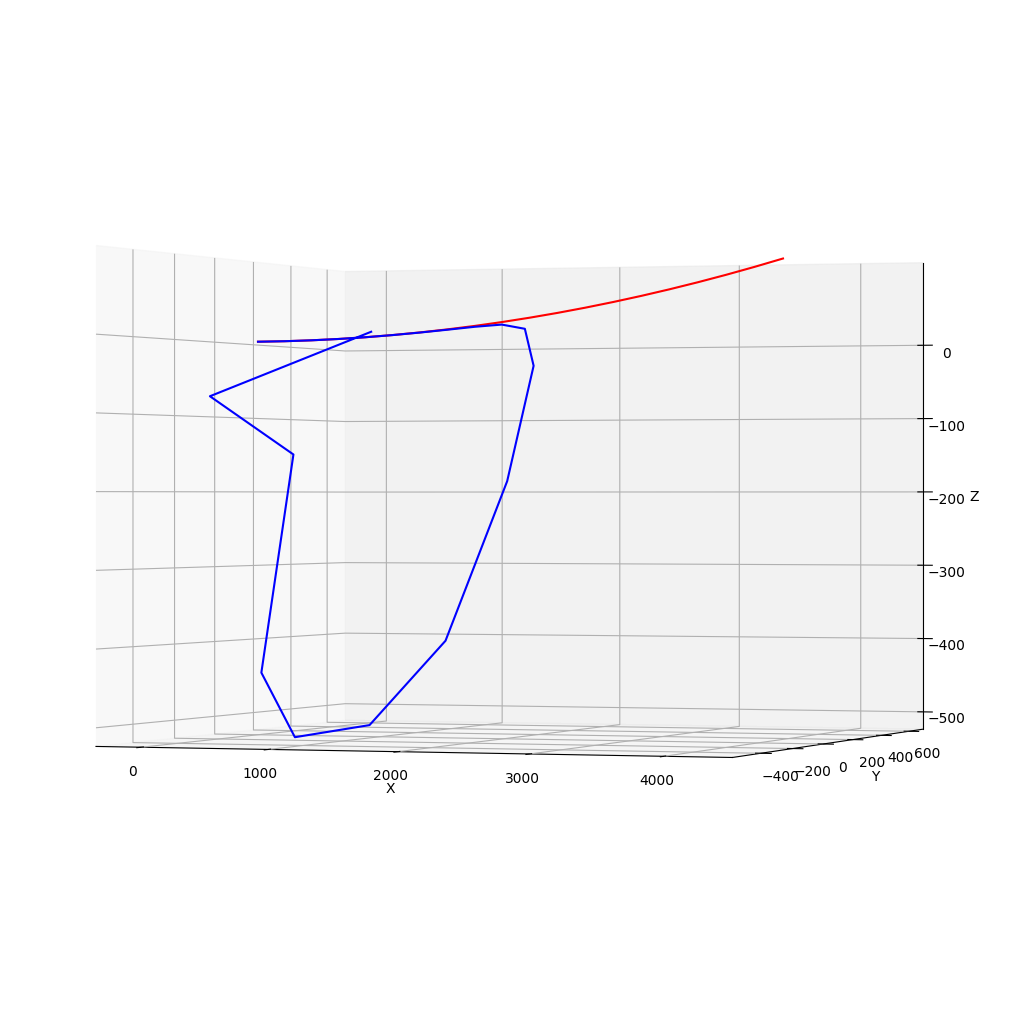

In [111]:
fig=plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection = '3d')

X0=fin[0,[i for i in range(0,N)]]
Y0=fin[0,[i for i in range(2*N,3*N)]]
Z0=fin[0,[i for i in range(4*N,5*N)]]

j=-1
X=fin[j,[i for i in range(0,N)]]
Y=fin[j,[i for i in range(2*N,3*N)]]
Z=fin[j,[i for i in range(4*N,5*N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b')
# ax.plot(x_fine, y_fine, z_fine, color='b')
# ax.view_init(-45,-45)
# ax.view_init(-30,-30)
ax.view_init(0,-70)
plt.show()

In [112]:
X,Y,Z

(array([-9.19197403e-06,  2.20749423e+02,  4.41498843e+02,  6.62248211e+02,
         8.82997037e+02,  1.10374035e+03,  1.32443999e+03,  1.54485649e+03,
         1.76368939e+03,  1.97479501e+03,  2.15458867e+03,  2.23675719e+03,
         2.10991309e+03,  1.76634357e+03,  1.36871724e+03,  1.05030166e+03,
         8.14951070e+02,  6.56821754e+02, -5.00237984e+01, -9.81446188e+00]),
 array([-9.19146027e-06,  2.04582401e-03,  2.04942713e-02,  5.92648836e-02,
         1.48387330e-01,  3.50835216e-01,  7.90987686e-01,  1.70270089e+00,
         3.50020263e+00,  6.71565437e+00,  1.03511840e+01,  1.52192984e+00,
        -5.85900289e+01, -1.61135362e+02, -2.98841747e+02, -4.73350390e+02,
        -4.91018541e+02, -2.31073534e+02, -2.12100660e+02,  6.20920150e+02]),
 array([-9.62410848e-06,  2.78767108e-01,  1.11084323e+00,  2.49565081e+00,
         4.42728160e+00,  6.88908518e+00,  9.84034436e+00,  1.31870545e+01,
         1.66842658e+01,  1.92317840e+01,  1.34383593e+01, -3.52429480e+01,
        

In [113]:
X0,Y0,Z0

(array([   0.        ,  220.74943519,  441.49887038,  662.24830556,
         882.99774075, 1103.74717594, 1324.49661113, 1545.24604631,
        1765.9954815 , 1986.74491669, 2207.49435188, 2428.24378706,
        2648.99322225, 2869.74265744, 3090.49209263, 3311.24152781,
        3531.990963  , 3752.74039819, 3973.48983338, 4194.23926856]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([ 0.        ,  0.27664154,  1.10656789,  2.48978426,  4.42629935,
         6.91612533,  9.95927782, 13.55577595, 17.70564231, 22.40890298,
        27.66558749, 33.47572887, 39.83936361, 46.7565317 , 54.22727659,
        62.25164521, 70.82968796, 79.96145874, 89.64701491, 99.88641731]))

In [114]:
us=fin.T

In [115]:
us.shape

(240, 1268)

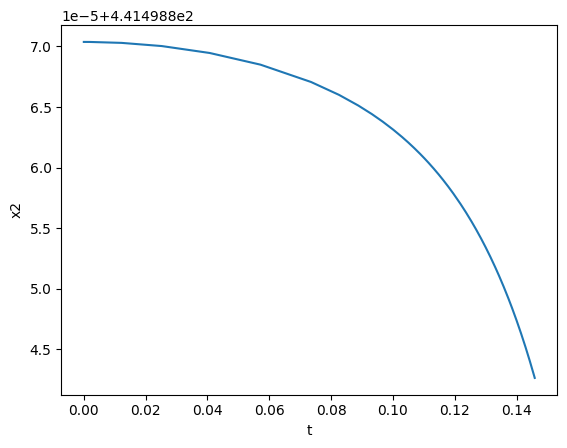

In [116]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

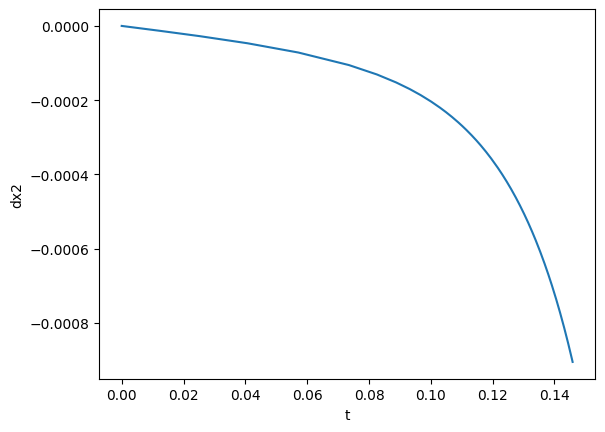

In [117]:
plt.plot(t,us.T[:,N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

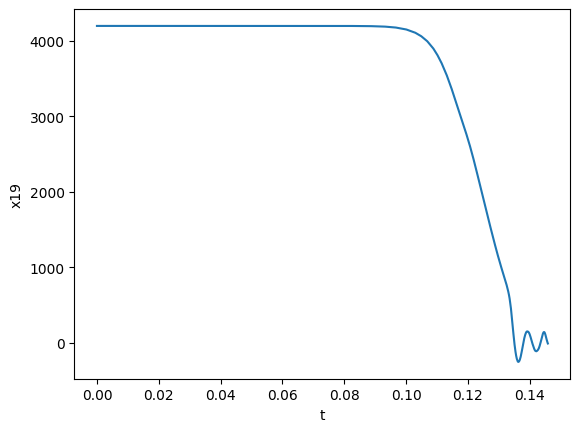

In [118]:
plt.plot(t,us.T[:,N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x19')
plt.show()

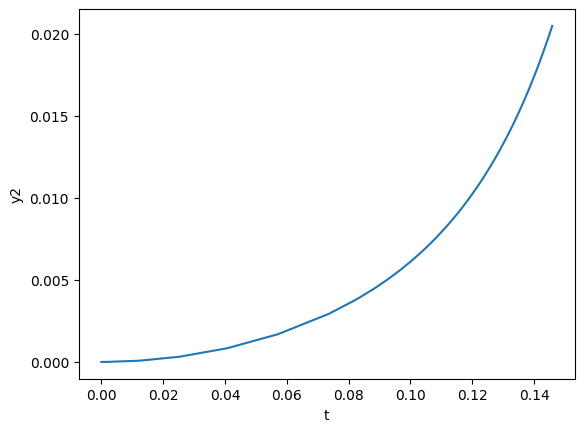

In [119]:
plt.plot(t,us.T[:,2*N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

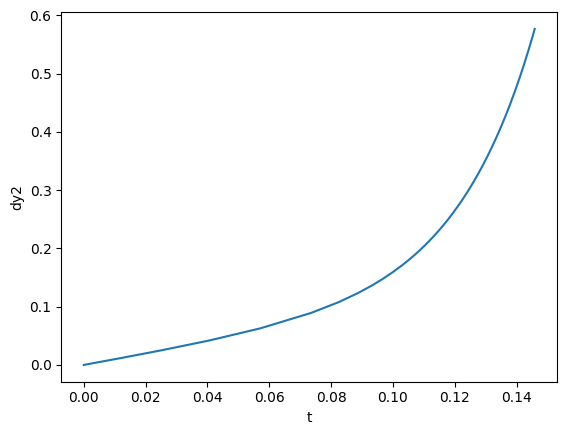

In [120]:
plt.plot(t,us.T[:,3*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

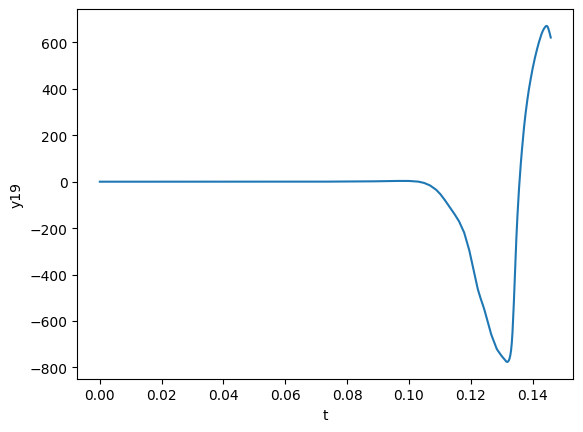

In [121]:
plt.plot(t,us.T[:,2*N+(N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('y19')
plt.show()

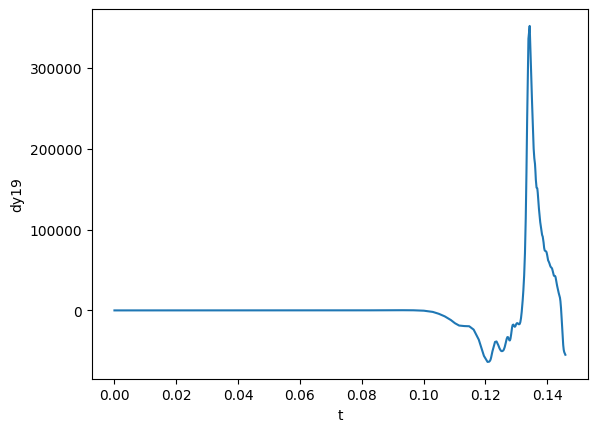

In [122]:
plt.plot(t,us.T[:,3*N+(N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('dy19')
plt.show()

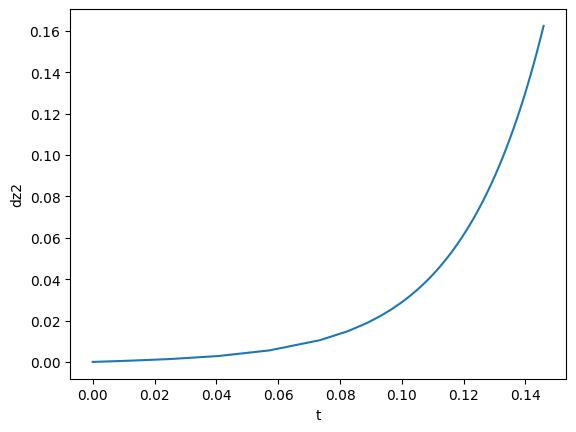

In [123]:
plt.plot(t,us.T[:,5*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

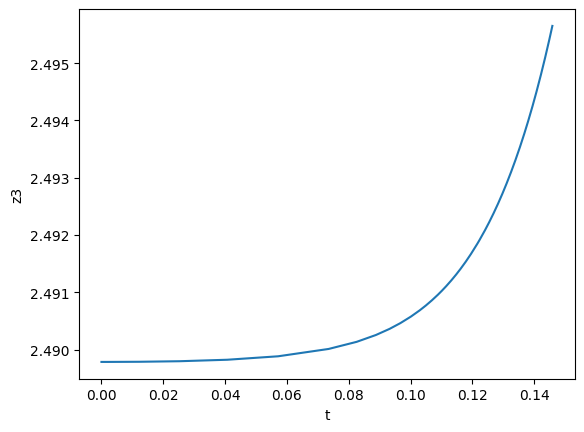

In [124]:
plt.plot(t,us.T[:,4*N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

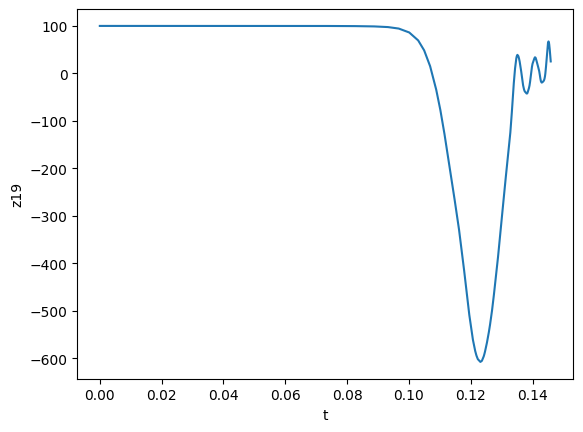

In [125]:
plt.plot(t,us.T[:,4*N + (N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('z19')
plt.show()

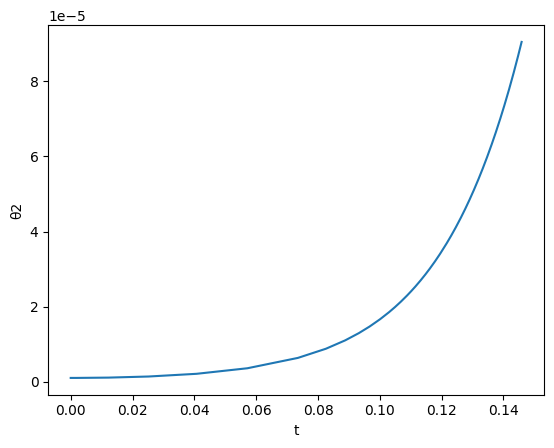

In [126]:
plt.plot(t,us.T[:,8*N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

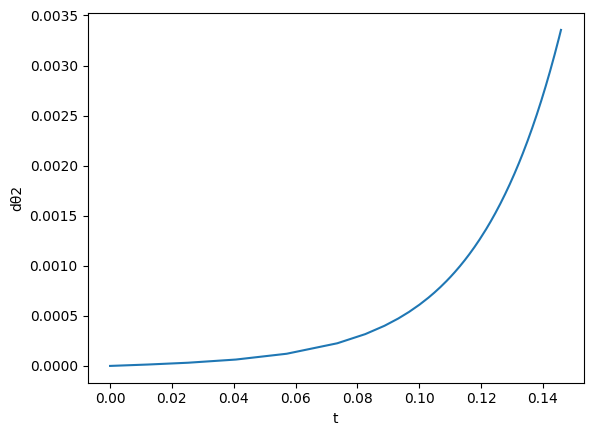

In [127]:
plt.plot(t,us.T[:,9*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

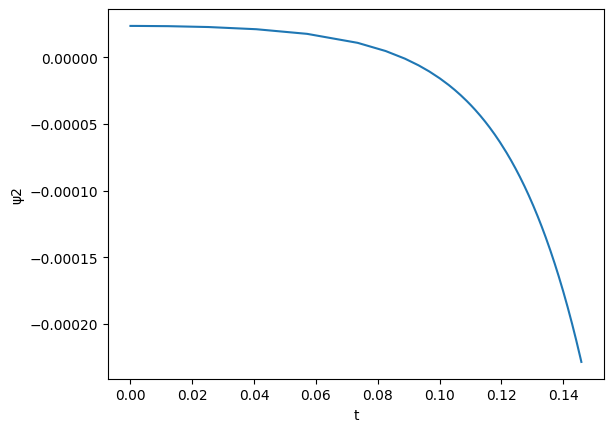

In [128]:
plt.plot(t,us.T[:,10*N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

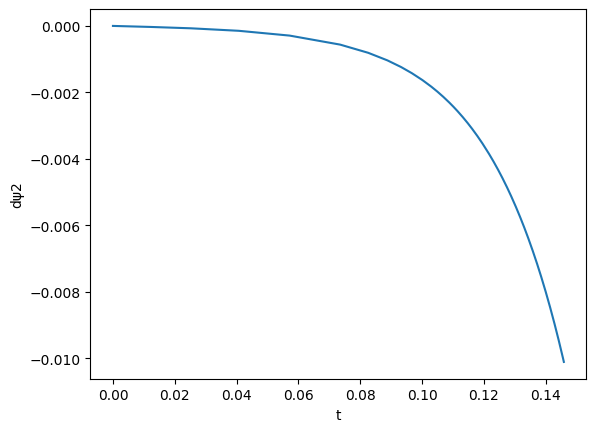

In [129]:
plt.plot(t,us.T[:,11*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()

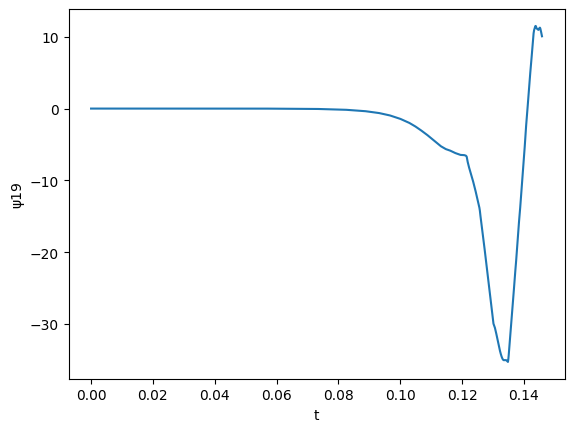

In [130]:
plt.plot(t,us.T[:,10*N + (N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('ψ19')
plt.show()